## Imports

In [2]:
## All library imports ##

#Basic imports
import numpy as np
import matplotlib.pyplot as plt

#For linear regression fit
import scipy.stats

#For handling the data
import pandas as pd

#For changing/choosing dates
from datetime import datetime as dt
from dateutil.rrule import rrule, MONTHLY, YEARLY
from dateutil.rrule import *

#For creating the psd plot
from scipy import signal

#For interpolating data
from scipy import interpolate
from scipy import stats

#For fourier transforms
from scipy.fft import fft, ifft

#For creating copies of data
import copy

#Heatmaps
import seaborn as sb

# #Exponential Orthogonal Functions, EOF's
# from eofs.standard import Eof

In [4]:
#Importing the minutely and hourly data
#Using minutely data from DeepCove, DiscoveryElementary, Helgesen, JamesBay, Keating, UVicSCI, JohnMuir
#Using hourly data from 35 stations

#Creating paths for all 7 minutely stations
Dir = "minutely_2019\\"
path_min_deep = "DeepCove_temperature_2019.dat"
path_min_disco = "DiscoveryElementary_temperature_2019.dat"
path_min_helg = "Helgesen_temperature_2019.dat"
path_min_james = "JamesBay_temperature_2019.dat"
path_min_keat = "Keating_temperature_2019.dat"
path_min_sci = "UVicSci_temperature_2019.dat"
path_min_john = "JohnMuir_temperature_2019.dat"

#Temperature, minute
info = pd.read_table(Dir+path_min_deep, sep="\s+", names=["deep"])
tempm_deep = pd.read_table(Dir+path_min_deep, sep="\s+", names=["deep"], skiprows=3)
tempm_disco = pd.read_table(Dir+path_min_disco, sep="\s+", names=["disco"], skiprows=3)
tempm_helg = pd.read_table(Dir+path_min_helg, sep="\s+", names=["helg"], skiprows=3)
tempm_james = pd.read_table(Dir+path_min_james, sep="\s+", names=["james"], skiprows=3)
tempm_keat = pd.read_table(Dir+path_min_keat, sep="\s+", names=["keat"], skiprows=3)
tempm_sci = pd.read_table(Dir+path_min_sci, sep="\s+", names=["sci"], skiprows=3)
tempm_john = pd.read_table(Dir+path_min_john, sep="\s+", names=["john"], skiprows=3)

#Creating an array of coordinates for all the hourly stations
coords = np.array([[236.5540,48.5745],[236.4990,48.5376],[236.6790,48.4655],[236.6070,48.4608],[236.5140,48.4356],\
                   [236.6300,48.5273],[236.5230,48.4529],[236.5430,48.6804],[236.6620,48.4562],[236.3040,48.3891],\
                   [236.6040,48.4382],[236.4300,48.6600],[236.7000,48.4651],[236.4710,48.4281],[236.4460,48.3640],\
                   [236.6200,48.4169],[236.2500,48.3710],[236.2830,48.3874],[236.5970,48.5677],[236.5770,48.6258],\
                   [236.6350,48.4788],[236.4940,48.4655],[236.6720,48.4451],[236.6390,48.5014],[236.5950,48.4253],\
                   [236.6700,48.4161],[236.6860,48.4182],[236.5790,48.6701],[236.6390,48.4456],[236.6410,48.4683],\
                   [236.6190,48.4744],[236.5140,48.4205],[236.3570,48.6568],[236.5740,48.4533],[236.5960,48.6529],\
                   [236.6760,48.4865],[236.6910,48.4623],[236.6890,48.4359],[236.4510,48.4572]])

#Coordinates for minutely data
min_coords = np.array([coords[7],[236.349,48.652],coords[14],coords[15],coords[16],coords[18],coords[36]])

#Stations, minutely
statm = ["DeepCove","Discovery","Helgesen","JamesBay","JohnMuir","Keatings","UVic"]
N = info.deep[2]
startmd = info.deep[0] - (365+1) #Start time, minutely
mins = np.arange(N)/(24*60)
greg_time = pd.DataFrame(mins+startmd, columns=["timeg"]) #Time m g = time, minutely, Gregorian

#All of the minutely temperature data for the 7 stations + time data
tempm = pd.concat([greg_time,tempm_deep,tempm_disco,tempm_helg,tempm_james,tempm_keat,tempm_sci,tempm_john],axis=1)

In [6]:
#Importing hourly data


Dir = "hourly_2019\\"

#Stations, hourly
stath = ["Brentwood","CalRevelle","CampusView","Colquitz","Colwood","CordovaBay","CrystalView","DeepCove",\
           "Doncaster","EdwardMilne","Esquimalt","FrancesKelsey","FrankHobbs","HappyValley","Helgesen","JamesBay",\
           "JonMuir","Journey","Keating","Kelset","Lakehill","Lakewood","Lansdowne","Lochside","Macaulay",\
           "MargaretJenkins","Monterey","Parkland","Quadra","Reynolds","Rogers","Sangster","ShawniganSchool",\
           "Shoreline","Sidney","Torquay","UVicSci","Willows","Willway"]

indices = pd.DataFrame(statm)
coast = pd.read_table("Coast.dat", sep="\s+", names=["Longitude","Latitude"])

#All temps + time (not Gregorian)
temph = pd.read_table(Dir+"AllStations_temperature_h_2019.dat", sep="\s+", header=1, names=["time"]+stath)
temph["timeg"] = temph.time-(365+1) #Gregorian time
cols = temph.columns.tolist()
cols = cols[-1:]+cols[:-1] #Moves Gregorian time from last index to first
temph = temph[cols] #Sets the hourly data to the specifications in the cols temp variable

#Dropping the "time" column for hourly ONLY
temph = temph.drop(columns="time")

## Analysis 

In [7]:
## Figuring out which data needs to be removed ##

def matrix(df): #Pass in a dataframe
    N = len(df.columns)
    matrix = np.zeros((N,len(df))) #CReating a matrix of data for ease of viewing
    rm = [] #Removing only the time columns
    
    for i in range(N):
        if df.columns[i] == "time":
            rm.append(i)
        elif df.columns[i] == "timeg":
            rm.append(i)
        else:
            matrix[i] = df[df.columns[i]]
    
    matrix = np.delete(matrix,rm,axis=0) #Deletes rows from "bad" matrix
    return matrix

In [8]:
## Creating and implementing a ticks function to use for plots ##

def ticks(start,end,freq):

    years = end[0] - start[0]
    months = end[1]-start[1]+12*years
#     print(years)
#     print(months)
    Dates = []
    if freq == True:
        ticks = np.zeros(years+1)
        Temp = np.array(list(rrule(YEARLY, dtstart = dt(start[0],start[1],start[2]),until = dt(end[0],end[1],end[2]))))
        for i in range(years+1):
            ticks[i] = dt.toordinal(Temp[i])
            Temp2 = Temp[i].date()
            Dates.append(str(Temp2))
    else:
        ticks = np.zeros(months+1)
        Temp = np.array(list(rrule(MONTHLY, dtstart = dt(start[0],start[1],start[2]), until = dt(end[0],end[1],end[2]))))
        for i in range(months+1):
            ticks[i] = dt.toordinal(Temp[i])
            Temp2 = Temp[i].date()
            Dates.append(str(Temp2))
    return Dates,ticks

<ipython-input-9-35dad562395a>:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xmesh,ymesh,matrix(tempm[3::2*1440]))


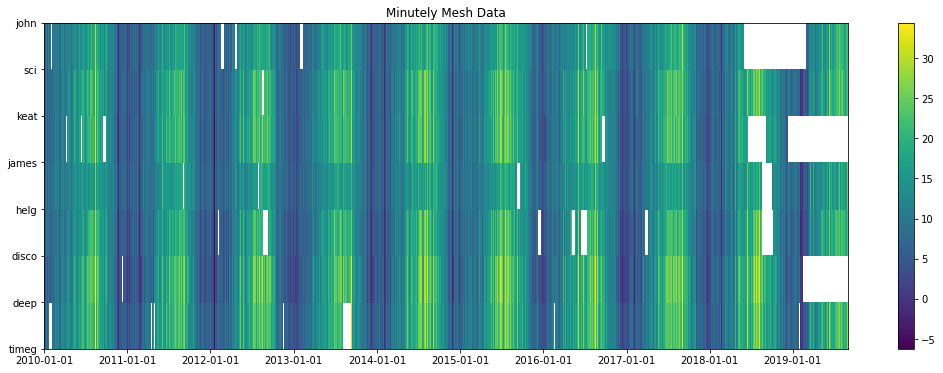

In [9]:
## Examining the data to see where there are 'holes' ##
#Will interpolate to fill them in later

tickmesh = ticks([2010,1,1],[2019,8,31],freq=True)

plt.figure(figsize=(18,6))
xmesh = tempm.timeg[3::2*1440]
ymesh = tempm.columns
plt.pcolormesh(xmesh,ymesh,matrix(tempm[3::2*1440]))
plt.title('Minutely Mesh Data')
plt.xticks(ticks=tickmesh[1], labels=tickmesh[0])
# plt.xticklabels(tickmesh[0])
plt.colorbar()
plt.show()

In [10]:
## Finding the firat and last dates ##
#In the hourly data

print("First" , dt.fromordinal(int(temph.timeg[0])))
print("Last" , dt.fromordinal(int(temph.timeg.iloc[-1])))

First 2008-01-01 00:00:00
Last 2019-08-31 00:00:00


<ipython-input-11-e1a890709567>:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xmesh1,ymesh1,matrix(temph))


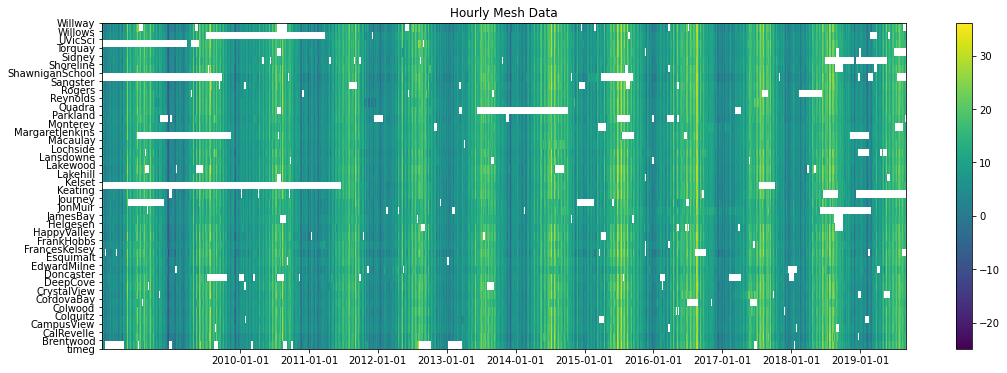

In [11]:
## Examining the data to see where there are 'holes' ##
#Will interpolate to fill them in later

tickmesh1 = ticks([2008,1,1],[2019,8,31],freq=True)

plt.figure(figsize=(18,6))
xmesh1 = temph.timeg
ymesh1 = temph.columns
plt.pcolormesh(xmesh1,ymesh1,matrix(temph))
plt.title('Hourly Mesh Data')
plt.xticks(ticks=tickmesh[1], labels=tickmesh[0])
# plt.xticklabels(tickmesh[0])
plt.colorbar()
plt.show()

In [12]:
## Interpolating blank spots in data ##
#Filling with cubic spline interpolation

def interp_nans(temp): #Takes in all temp data
    temps_new = copy.deepcopy(temp) #Copies temperature data to prevent overwriting
    data_new = []
    for data in temps_new: #data = array from each of the stations
        nanmask = np.isnan(data) #Creates mask of True = nan value, False = real value
        data[nanmask] = np.nanmean(temps_new.T[nanmask], axis=1) 
        #Replaces nan values with means in a given column across all stations
        data_new.append(data)
        
    return data_new


#Turn into a function
def min_interp_cubic(station_clean, time): #station_clean = no nans, time = minutes
    remove = np.where(np.isnan(station_clean)==True) #Finding locations where there are nans
    rm_mask = ~np.isnan(station_clean) #Creating a 'mask' of these nan values
    spline = scipy.interpolate.CubicSpline(time[rm_mask],station_clean[rm_mask])
    values = spline(time[remove])
    
    return (values,remove)#Turn into a function
    #values = clean data
    #

#Minutely
tempm_clean = interp_nans(np.array(tempm.drop(columns="timeg")).T) #Will be the 'cleaned' minutely temperature array
tempm_clean = np.aray(tempm_clean) #Converted to array to use later

#Hourly
temph_clean = interp_nans(np.array(temph.drop(columns="timeg")).T)
temph_clean = np.array(temph_clean)

for station in tempm_clean:
    vals, rm = min_interp_cubic(station,np.array(tempm.timeg))
    station[rm] = vals
    
for station in temph_clean:
    vals, rm = min_interp_cubic(station,np.array(temph.timeg))
    station[rm] = vals

<ipython-input-12-7cb25990e8f0>:9: RuntimeWarning: Mean of empty slice
  data[nanmask] = np.nanmean(temps_new.T[nanmask], axis=1)


In [11]:
# ## Debugging shit ##

# np.where(np.isnan(tempm_clean) == True) 
# #Tells you if the interpolation worked properly 

In [18]:
## Converting back to a Pandas dataframe ##

tempm1 = pd.DataFrame(tempm_clean.T,columns=statm) #Use this from here
#Does NOT contain timeg! Have to use tempm.timeg to access time values
temph1 = pd.DataFrame(temph_clean.T,columns=stath)
temph1["timeg"] = temph.timeg

<ipython-input-23-e88c2cd27905>:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xmesh,ymesh,matrix(tempm1[3::2*1440]))


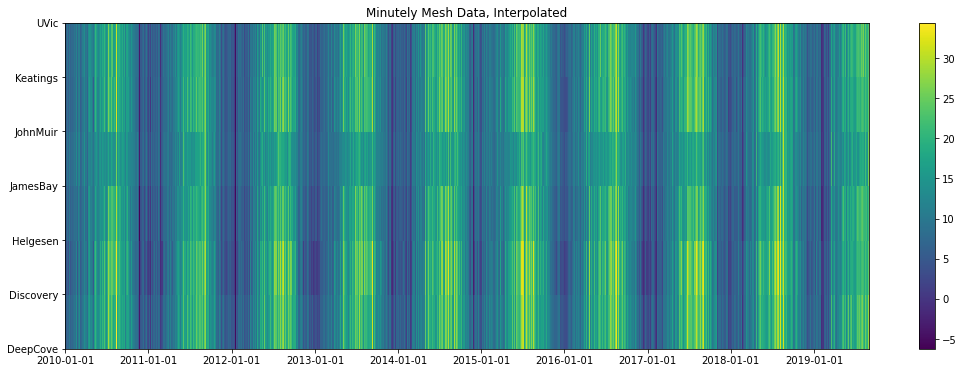

In [23]:
## Plotting the cleaned mesh data, minutely ##

plt.figure(figsize=(18,6))
xmesh = tempm.timeg[3::2*1440]
ymesh = tempm1.columns
plt.pcolormesh(xmesh,ymesh,matrix(tempm1[3::2*1440]))
plt.title('Minutely Mesh Data, Interpolated')
plt.xticks(ticks=tickmesh[1], labels=tickmesh[0])
# plt.xticklabels(tickmesh[0])
plt.colorbar()
plt.show()

<ipython-input-29-c0f7ccb751df>:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xmesh1,ymesh1,matrix(temph1))


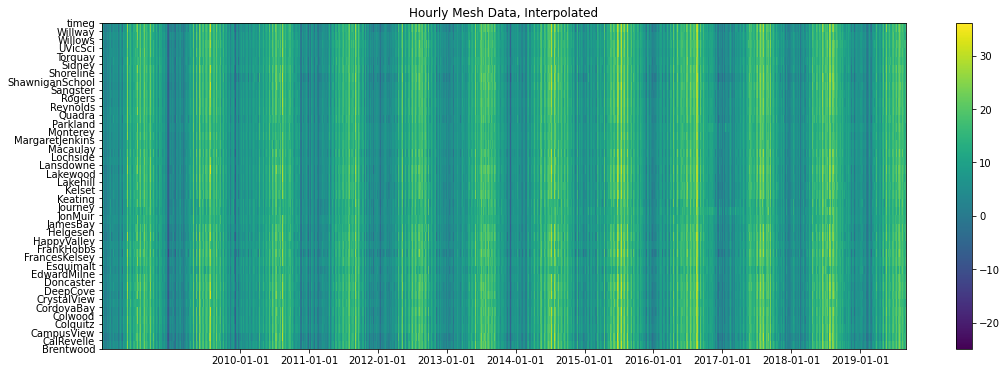

In [29]:
## Plotting the cleaned mesh data, hourly ##

plt.figure(figsize=(18,6))
xmesh1 = temph1.timeg
ymesh1 = temph1.columns
plt.pcolormesh(xmesh1,ymesh1,matrix(temph1))
plt.title('Hourly Mesh Data, Interpolated')
plt.xticks(ticks=tickmesh[1], labels=tickmesh[0])
# plt.xticklabels(tickmesh[0])
plt.colorbar()
plt.show()

In [30]:
## For creating confidence intervals on the PSD plots ##

def conf_int(x):
    NFFT = 2**14
    n = int(len(x)/NFFT)
    num_seg = 2*n - 1
    nu = (4/3)*num_seg

    #95% CI
    alpha = 1 - 95/100
    chiu = stats.chi2.ppf(alpha/2,nu) #ppf gives inverse of chi^2 dist, chi_upper
    chil = stats.chi2.ppf(1-alpha/2,nu) #chi_lower
    erru = nu/chiu #Upper confidence limit
    errl = nu/chil #Lower limit
    
    return (errl,erru)

In [31]:
 ## Implementing 'the basics' to the minutely data ##
    
def gauss_pdf(x,mu,sigma):
    A = 1/(sigma*np.sqrt(2*np.pi))
    B = 0.5*((x-mu)/sigma)**2
    p = A*np.exp(-B)
    return p


def basic_plots(temp,name,col): #temp from a given station
    
    #Basic values
    mean = np.mean(temp)
    median = np.median(temp)
    std = np.std(temp)
    mintemp = np.min(temp)
    maxtemp = np.max(temp)
    fs = 1/60 #Sampling frequency
    NFFT = 2**14
    
    #Creating PSD
    Gamma = scipy.signal.welch(temp,fs,nperseg=NFFT) #PSD
    errl,erru = conf_int(temp) #Lower, upper CI for PSD
    
    
    plt.figure(figsize=(16, 10))
    plt.suptitle(name)
    plt.tight_layout()
    ax1 = plt.subplot(2,3,1)
    ax2 = plt.subplot(2,3,2)
    ax3 = plt.subplot(2,3,3)
    ax4 = plt.subplot(2,1,2)
    axes = [ax1, ax2, ax3, ax4]
    
    #Creating PDF
    ax1.hist(temp,bins=60,density=True,color=col,edgecolor='k') #Density = True, normalizes the PDF
    #Note that normalizing is ESSENTIAL for getting the Gaussian fit to work
    x = np.linspace(min(temp),max(temp),len(temp))
    label = 'Gaussian fit \n $\mu$ = {:.3f} \n $\sigma$ = {:.3f}'.format(mean,std)
    ax1.plot(x,gauss_pdf(x,mean,std),color='r',label=label)
    ax1.set_xlabel('Temperature (°C)')
    ax1.set_ylabel('Normalized Counts')
    ax1.set_title('Normalized PDF')
    ax1.legend(loc="upper right")
    
    
    ax2.loglog(Gamma[0],Gamma[1],color=col)
    ax2.fill_between(Gamma[0],Gamma[1]*errl,Gamma[1]*erru,alpha=0.5,color='m')
    ax2.set_title('PSD')
    ax2.set_xlabel('Frequency [cpd]')
    ax2.set_ylabel("$\Gamma$ [$°C^2$/Hz] ")
    
    ax3.semilogx(Gamma[0],Gamma[0]*Gamma[1],color=col)
    ax3.set_title('Variance-Preserving PSD')
    ax3.set_xlabel("Frequency [cpd]")
    ax3.set_ylabel(r"f·$\Gamma(f)$ [$°C^2$]")
    
    #Time Series
    tick = ticks([2010,1,1],[2019,8,31],freq=True)
    ax4.plot(tempm.timeg,temp,color=col)
    ax4.set_title('Time Series')
    ax4.set_xticks(tick[1])
    ax4.set_xticklabels(tick[0])
    ax4.set_ylabel('Temperature [°C]')
    ax4.set_xlabel('Time [date]')
    
#     plt.savefig("Basics_"+name+".png")
    
    
    print("Mean temperature: %.3f" % mean , "°C")
    print("Standard deviation in temperature: %.3f" % std , "°C")
    print()

Mean temperature: 10.956 °C
Standard deviation in temperature: 6.176 °C

Mean temperature: 9.943 °C
Standard deviation in temperature: 7.149 °C

Mean temperature: 10.296 °C
Standard deviation in temperature: 5.705 °C

Mean temperature: 10.213 °C
Standard deviation in temperature: 4.615 °C

Mean temperature: 10.649 °C
Standard deviation in temperature: 5.941 °C

Mean temperature: 11.181 °C
Standard deviation in temperature: 5.544 °C

Mean temperature: 10.174 °C
Standard deviation in temperature: 5.065 °C



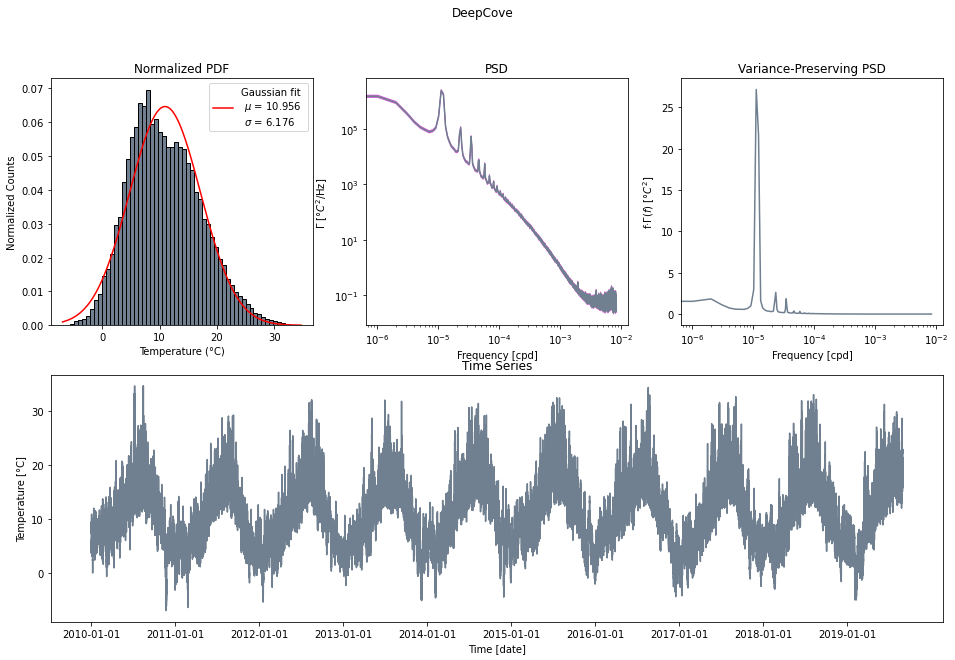

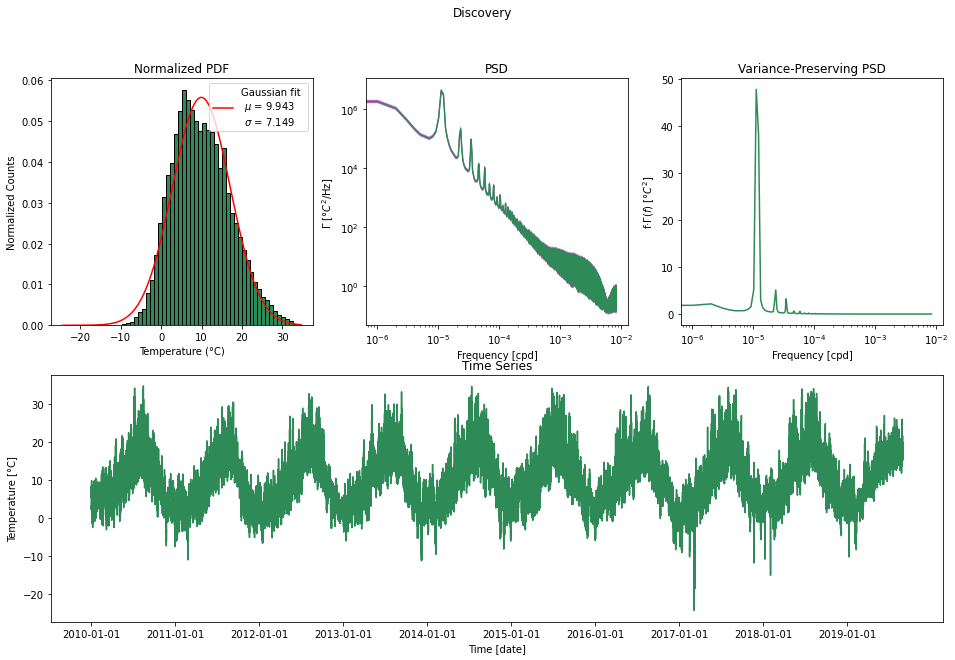

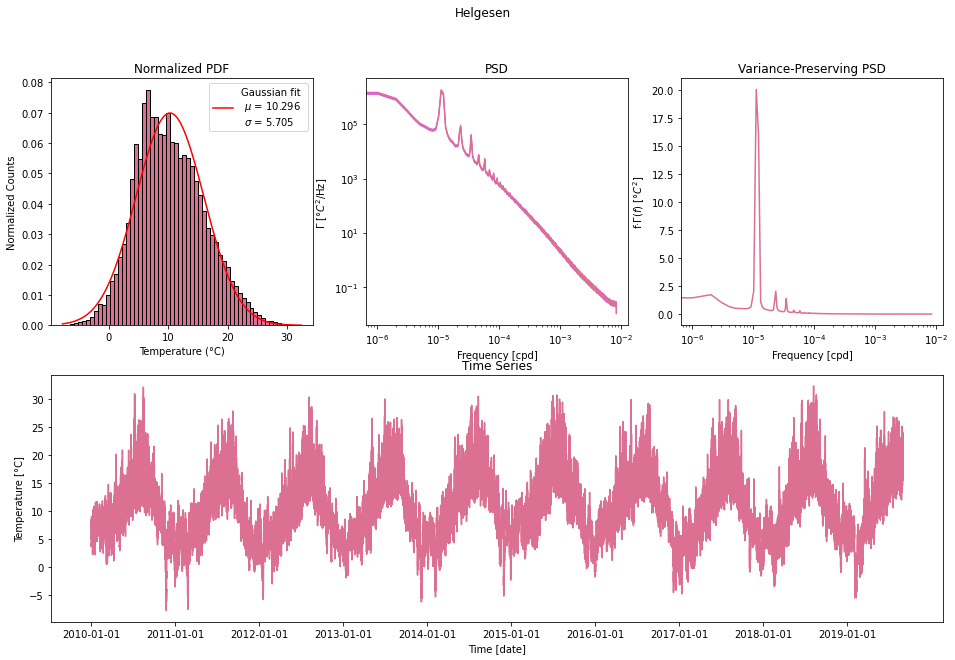

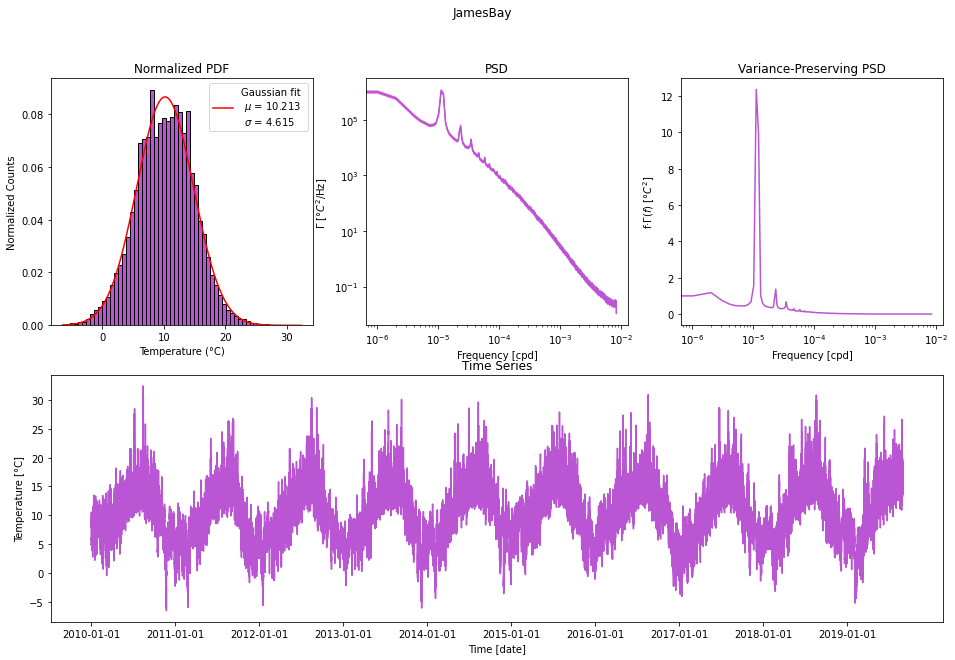

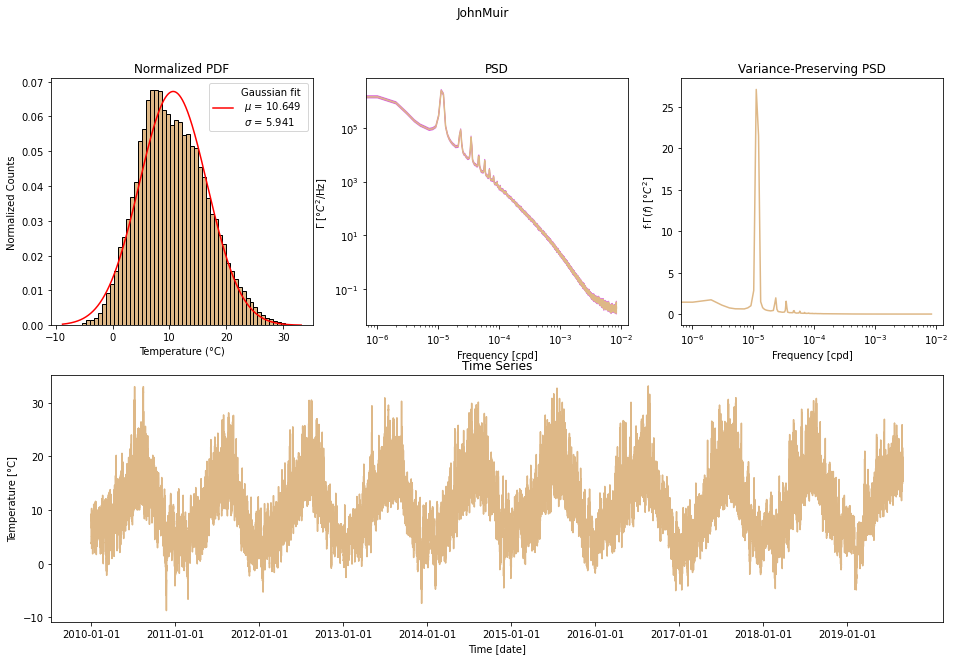

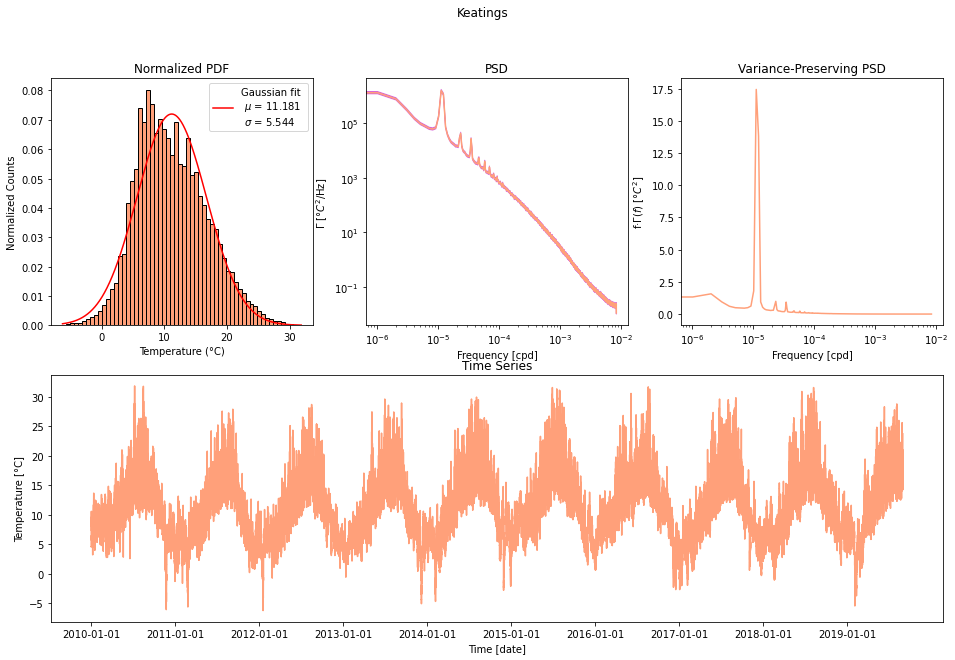

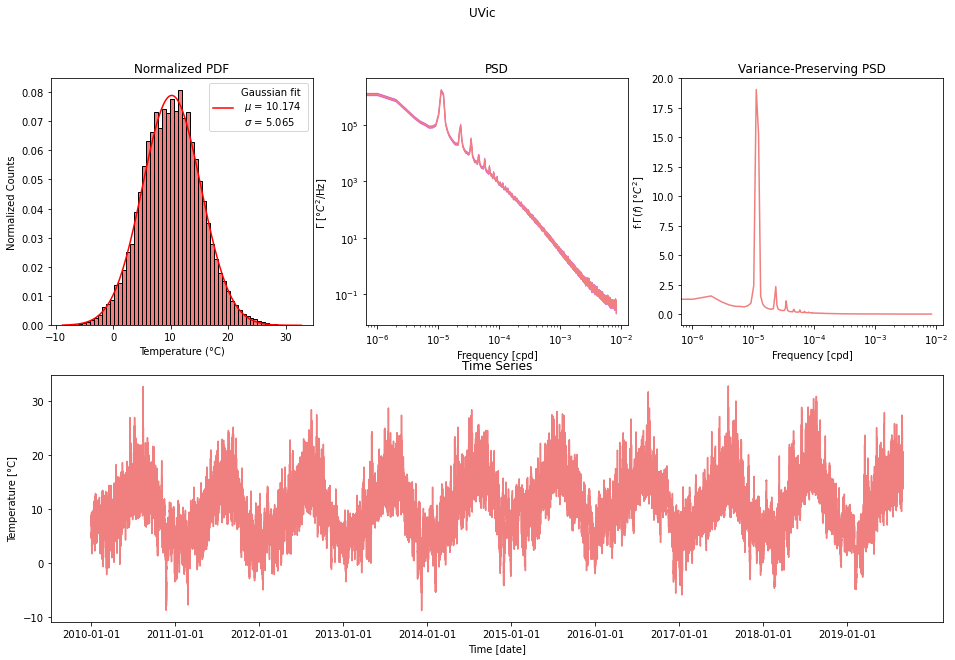

In [32]:
# basic_plots(tempm1['DeepCove'],'DeepCove','slategray')

##KEEP
plot_colors = ['slategray','seagreen','palevioletred','mediumorchid','burlywood','lightsalmon','lightcoral']

for station,color in zip(statm,plot_colors):
    basic_plots(tempm1[station],station,color)

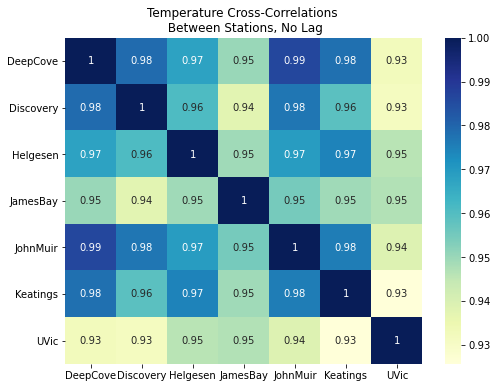

In [33]:
## Find cross-correlations between stations ##

tempm1_corr = tempm1.corr() #Creates a correlation matrix

plt.figure(figsize=(8,6))
sb.heatmap(tempm1_corr,annot=True,cmap='YlGnBu')
plt.title('Temperature Cross-Correlations \n Between Stations, No Lag')
# plt.savefig('CrossCorr_nolag.png')
plt.show()

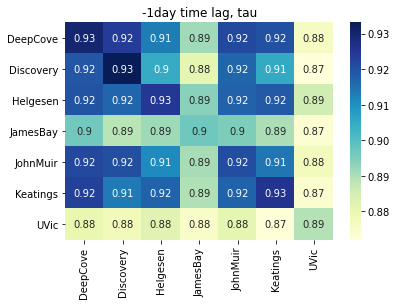

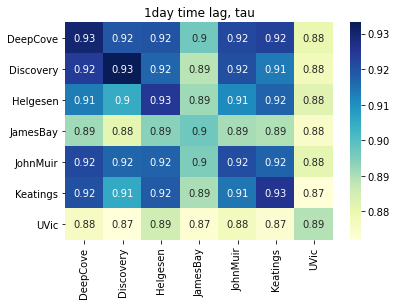

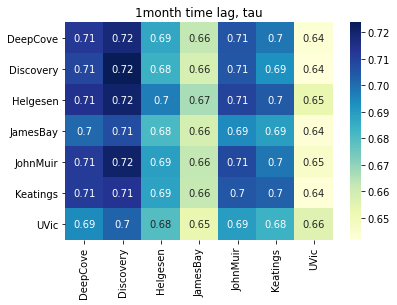

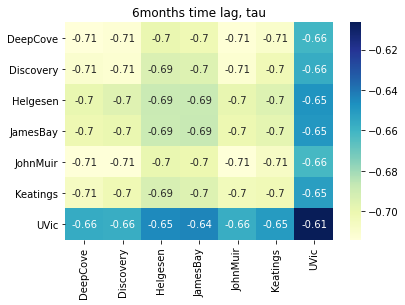

In [34]:
## Finding auto-correlations between stations ##
#With a given time lag

def corrlag(data1,data2,tau): #tau = time lag
    return tempm1[data1].corr(tempm1[data2].shift(tau))

day = 24*60 #24hrs*60mins
lags = [-day,day,30*day,int((365/2)*day)] #tau values, -1 day, 1 day, 1 month, 6 months
lags_strings = ['-1day','1day','1month','6months']

def plot_corrlag(tau):
    tempm1_lagcorr = []
    for station1 in tempm1:
        corr_li = []
        for station2 in tempm1:
            corr_li.append(corrlag(station1,station2,tau))
        tempm1_lagcorr.append(corr_li)
    return pd.DataFrame(tempm1_lagcorr,columns=statm,index=statm)

for tau,label in zip(lags,lags_strings):
    sb.heatmap(plot_corrlag(tau),annot=True,cmap='YlGnBu')
    plt.title(label+' time lag, tau')
#     plt.savefig('CrossCorr_'+label+'.png')
    plt.show()

In [38]:
## Interpolating coastal data onto longitude/latitude grid ##

filename = 'AllStations_temperature_h_2019.dat'
# hour_data_all = pd.read_csv(filename, sep="\s+", names=["time"]+stath)
# hour_data_all.time = hour_data_all.time - (365+1)

#Loading the hourly longitude, latitude data from hourly
coastal = pd.read_csv("Coast.dat", sep="\s+", names=["long","lat"])

df_longlat = pd.read_csv(Dir+filename, sep="\s+", names=["time"]+stath).head(2)
long = np.array(df_longlat.iloc[0].drop("time"))
lat = np.array(df_longlat.iloc[1].drop("time"))
# long = np.array(df_longlat.iloc[0])
# lat = np.array(df_longlat.iloc[1])


def coastal_map(data,name):

    #Red dots data
    #No lat convert needed
    #48.6 = aspect ratio conversion, so mep doesn't look skewed
    coast_long = coastal.long + 360 #(black lines)
    coast_lat = coastal.lat #(Black lines)

    aspect = np.cos(48.6*np.pi/180)
    plt.figure(figsize=(11*aspect*1.65,11))

    ax = plt.axes()
    ax.set_facecolor('darkslategray') #Adding an ocean background, just because
    plt.plot(coast_long,coast_lat,c='k')
    plt.fill(coast_long,coast_lat,zorder=0,color='darkolivegreen') #Filling in the land
    #zorder=0 puts it at the very back

    #Creating the heatmap contour
    xvals = np.linspace(np.min(coast_long),np.max(coast_long),1000) #Creating longitude values for contour 
    yvals = np.linspace(np.min(coast_lat),np.max(coast_lat),1000) #Latitude for contour
    xvals,yvals = np.meshgrid(xvals,yvals) #x,y spatial coordinates

    zvals = scipy.interpolate.griddata((long,lat),(data.mean()).drop("timeg"),(xvals,yvals),method='cubic')
#     zvals = scipy.interpolate.griddata((long,lat),data.mean(),(xvals,yvals),method='cubic')

    plt.contourf(xvals,yvals,zvals,15,alpha=0.6,cmap='jet')
    cb = plt.colorbar()
    cb.set_label(r'Temperature [$^oC$]')

    #Creating the scatter plot points to mark the stations
    plt.scatter(long, lat, marker='X', s=100 ,c='gold')
    plt.scatter(long, lat, marker='X', s=25, c='r')

    plt.title(name,fontsize=16)
    plt.xlabel(r'Longitude [$^o$]',fontsize=14)
    plt.ylabel(r'Latitude [$^o$]',fontsize=14)

    plt.xlim([236.2,236.75]) #Edge latitude coordinates
    plt.ylim([48.35,48.7]) #Edge longitude coordinates
    
#     plt.savefig(name+'.png')

    plt.show()

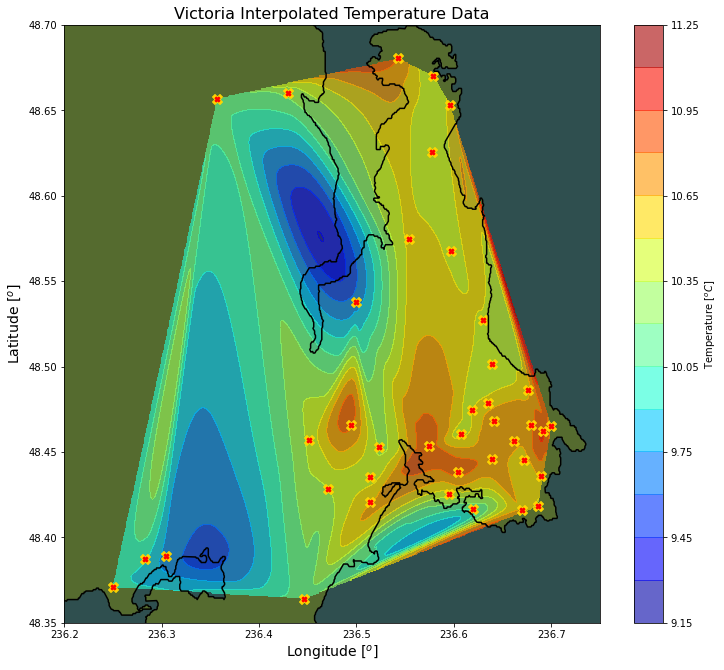

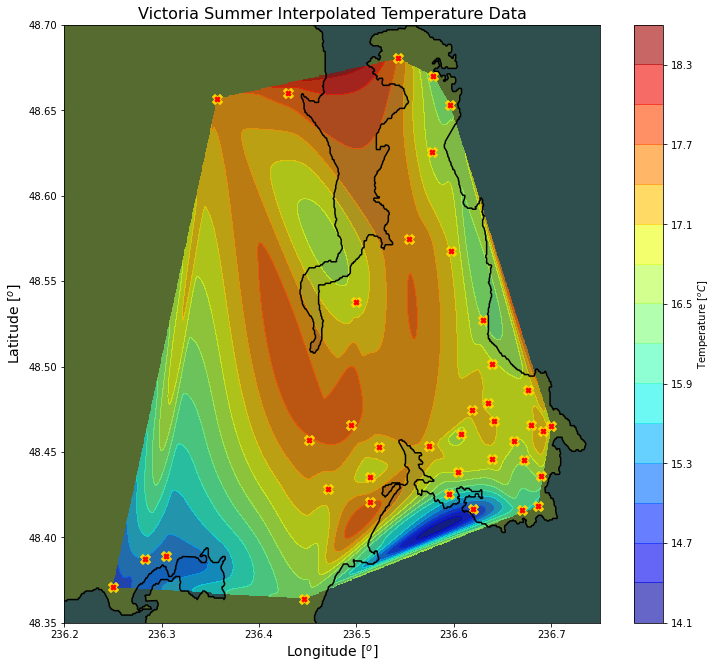

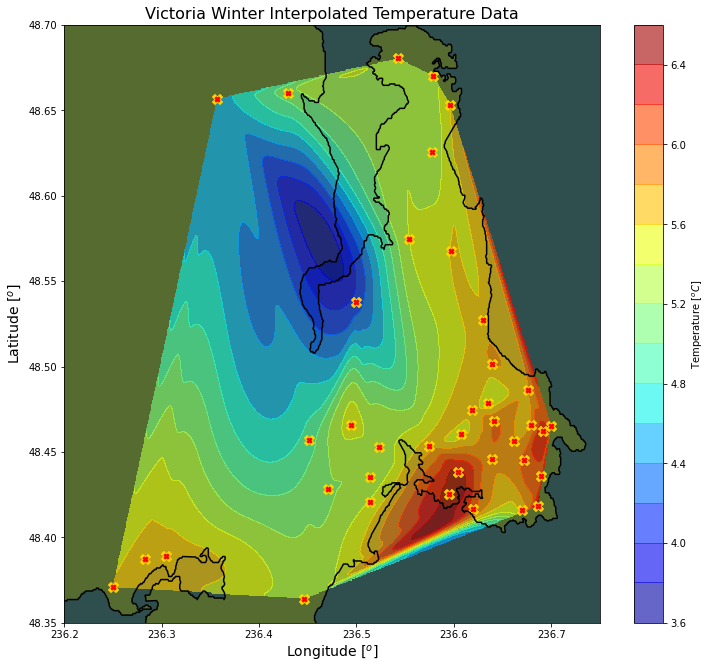

In [39]:
## Plotting the temp maps ##
#All data, winter, summer = 3 plots

#Choosing 2017 because I can
left1 = dt.toordinal(dt(2017,6,1))
right1 = dt.toordinal(dt(2017,10,1)) #Summer

left2 = dt.toordinal(dt(2018,11,1))
right2 = dt.toordinal(dt(2019,3,1)) #Winter

#Segmenting into summer and winter dataframes, temph_summer and temph_winter
tempo_summer = temph1[temph1.timeg >= left1] #Temporary variable, summer
temph_summer = tempo_summer[tempo_summer.timeg < right1]

tempo_winter = temph1[temph1.timeg >= left2] #Temporary variable, winter
temph_winter = tempo_winter[tempo_winter.timeg < right2]


coastal_map(temph1,'Victoria Interpolated Temperature Data')
coastal_map(temph_summer, 'Victoria Summer Interpolated Temperature Data')
coastal_map(temph_winter, 'Victoria Winter Interpolated Temperature Data')

In [20]:
# ## Creating EOF's ##

# def EOF(data):
    
#     coast_long = coastal.long + 360 #(black lines)
#     coast_lat = coastal.lat #(Black lines)

#     aspect = np.cos(48.6*np.pi/180)
#     plt.figure(figsize=(11*aspect*1.65,11))
    
#     #Creating the heatmap contour
#     xvals = np.linspace(np.min(coast_long),np.max(coast_long),1000) #Creating longitude values for contour 
#     yvals = np.linspace(np.min(coast_lat),np.max(coast_lat),1000) #Latitude for contour
#     xvals,yvals = np.meshgrid(xvals,yvals) #x,y spatial coordinates
# #     zvals = scipy.interpolate.griddata((long,lat),(data.mean()).drop("timeg"),(xvals,yvals),method='cubic')
    
#     data_new = data.drop(["timeg"],axis=1).to_numpy()
    
#     zvals_all = []
#     for dat in data_new:
#         zvals_all.append(scipy.interpolate.griddata((long,lat),dat,(xvals,yvals),method='cubic'))
        
#     solver = Eof(np.array(zvals_all,dtype='float')) #Assumes for each value of a griddata, is a new time point
#     EOF1 = solver.eofsAsCorrelation(neofs=3) #Returns first correlation function
#     pc1 = solver.pcs(npcs=3, pcscaling=1)
#     variance_fractions = solver.varianceFraction()
    
#     fig,((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(15,12))
    
#     ax1.plot(coast_long,coast_lat, c='k')
#     ax1.fill(coast_long,coast_lat, zorder=0)
#     ax1.scatter(long,lat,marker='X',size=100)
#     ax1.scatter(long,lat,marker='X',size=25)
    
#     ax2.plot(coast_long,coast_lat,c='k')
#     ax2.fill(coast_long,coast_lat,zorder=0)
    
#     ax3.plot(coast_long,coast_lat,c='k')
#     ax3.fill(coastlong,coast_lat,zorder=0)
    
#     ax4.plot(data['timeg'],pc1[:,0],color='b')
    
#     ax5.plot(data['timeg'],pc1[:,1],color='b')
    
#     ax6.plot(data['timeg'],pc1[:,2],color='b')
    

# EOF(temph1[::8])

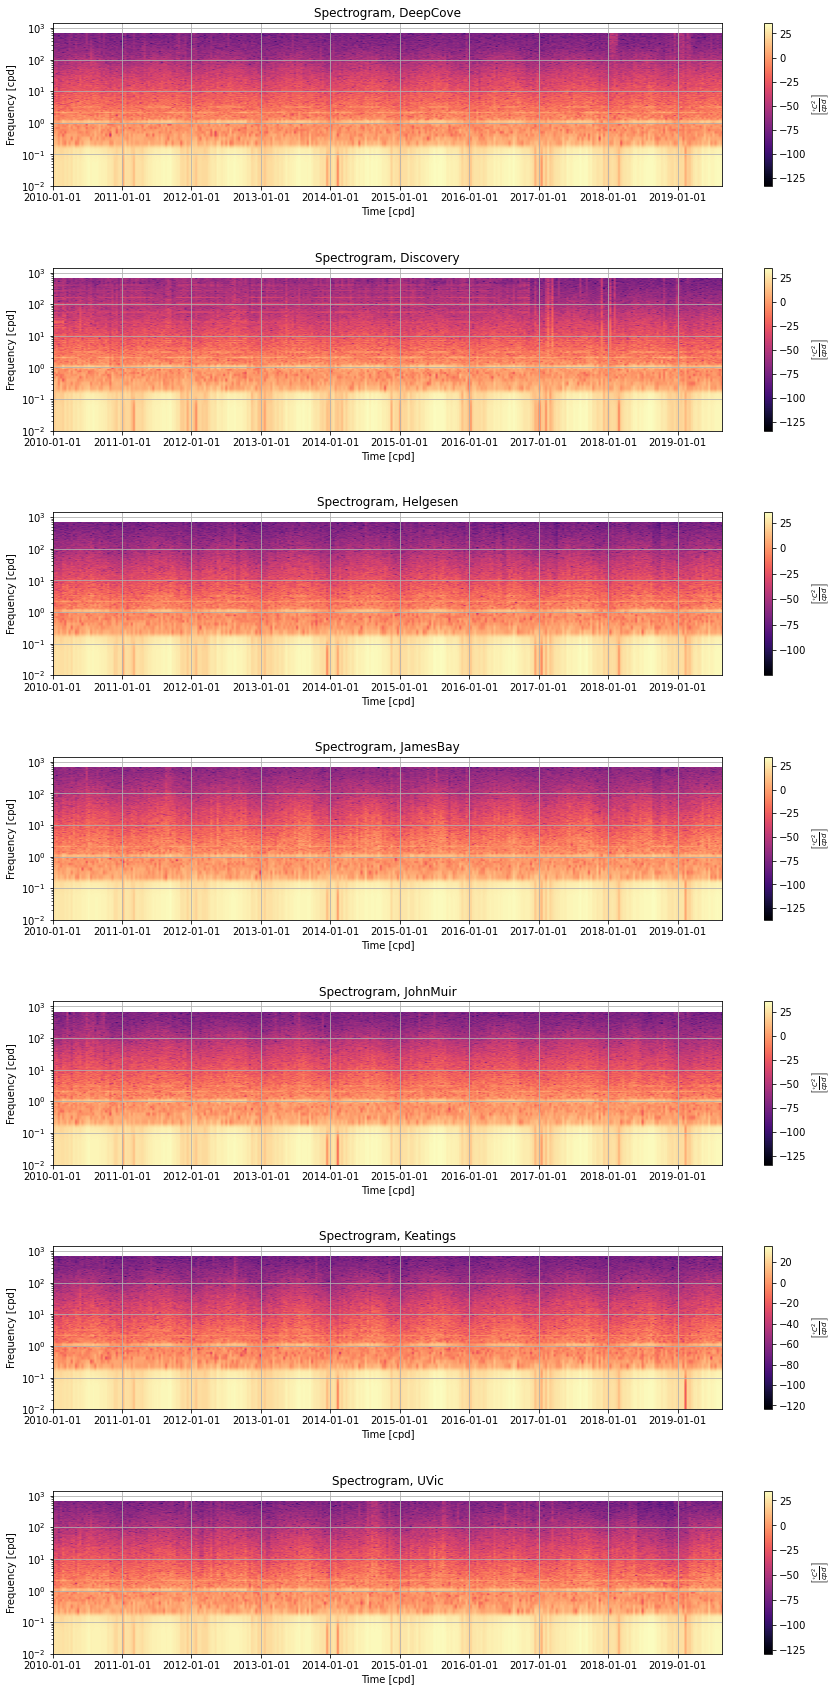

In [40]:
## Creating spectrogram ##

tempm1["timeg"] = tempm.timeg
min_ticks = ticks([2010,1,1],[2019,8,31],freq=True)
fs = 24*60

fig,axs = plt.subplots(int(len(statm)),1,figsize=(15,30), facecolor='w', edgecolor='k')
# fig,axs = plt.subplots(7,1,figsize=(15,30))
fig.subplots_adjust(hspace=.5,wspace=.25)
axs = axs.ravel()

i = 0
for name in statm:
    values,ybins,xbins,image = axs[i].specgram(tempm1[name], NFFT=2**14, Fs=fs, cmap='magma')
    axs[i].title.set_text(name)
    axs[i].set_xlabel("Time [cpd]")
    axs[i].set_ylabel("Frequency [cpd]")
    axs[i].set_yscale('log')
    axs[i].set_ylim(1e-2,fs)
    axs[i].set_title("Spectrogram, "+name)
    axs[i].set_xticks(min_ticks[1] - tempm1.timeg[0])
    axs[i].set_xticklabels(min_ticks[0])
    axs[i].grid()
    fig.colorbar(image, ax=axs[i], label=r"$\left[\frac{{}^{\circ}C^2}{cpd}\right]$")
    i+=1
#     plt.savefig("Spectrogram_"+name+".png")

Bin boundaries: [  6.05344514   8.17215094  11.03240377  14.89374509  20.10655587
  27.14385042  36.64419807  49.4696674   66.78405098  90.15846883
 121.71393292 164.31380944 221.82364274 299.4619177  404.2735889 ]
Maximum possible time pair value:  364.5833000000566
Max dtime should be less than only the last bin boundary.


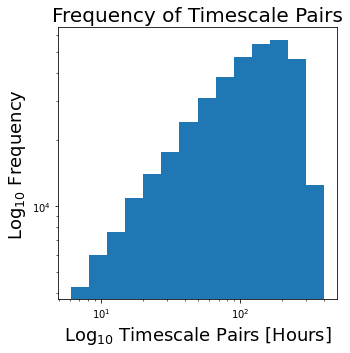

In [41]:
## Structure Function Analysis Pt.1 ##
#Creating the histogram

#Using data only for ONE year across stations for hourly data

left3 = dt.toordinal(dt(2014,1,1))
right3 = dt.toordinal(dt(2015,1,1))
tempo_year = temph1[temph1.timeg >= left3]
temph_year = tempo_year[tempo_year.timeg < right3]

# temph_year[::2] #Using half the data points for ease of computation
temph_year1 = temph_year[::10]
time = np.array(temph_year1.timeg)
#Use this one!!!
temph_year1 = temph_year1.drop("timeg",axis='columns') #Removes time column from the hourly temp for the specified year


num_stations = int(len(temph_year1.columns))
num_temps = int(len(temph_year1))
num_temppairs = int(num_temps*(num_temps-1)/2)
dtime = np.zeros(num_temppairs)
dtemp = np.zeros((num_stations,num_temppairs))


#Finding time pairs to use to make structure function
count = 0
for i in range(num_temps):
    for j in range(i+1,num_temps):
        dtime[count] = abs(time[i] - time[j])
        count += 1


inds = [ind for ind in range(len(stath))]
for name,ind in zip(stath,inds):       
    count = 0
    for j in range(num_temps):
        for k in range(j+1,num_temps):
            dtemp[ind][count] = abs(temph_year1[name].iloc[j] - temph_year1[name].iloc[k])
            #Appending temp pairs to the array
            count += 1
            
            
#Creating the bin separation values, ~exponential      
elem_time = int(14)
bins_time = [(1.35**(i+6)) for i in range(elem_time+1)]

plt.figure(figsize=(5,5))
plt.title('Frequency of Timescale Pairs', fontsize=20)
plt.ylabel('Log$_{10}$ Frequency', fontsize=18)
plt.xlabel('Log$_{10}$ Timescale Pairs [Hours]', fontsize=18)

(n,bins,patches) = plt.hist(dtime,bins=bins_time)
plt.xscale('log')
plt.yscale('log')
print("Bin boundaries:" , bins)
print("Maximum possible time pair value: " , max(dtime))
print("Max dtime should be less than only the last bin boundary.")

# plt.savefig('Histogram.png')

In [163]:
## Structure Function Analysis Pt.2 ##
#Finding the structure function

dtemp_sq = np.zeros((num_stations,num_temppairs)) #2D array for squared temperature pairs in each station
temp_med_sq = np.zeros(num_stations) #Squared median temperature for each source, scalar

#Appending values for the above variables
for i in range(num_stations):
    temp_med_sq[i] = (np.median(temph_year1[name]))**2
    for j in range(num_temppairs):
        dtemp_sq[i][j] = np.square(dtemp[i][j])
        
bins_time = np.asarray(bins_time)

SF = np.zeros((num_stations,elem_time)) #39x14

for i in range(num_stations):
    for j in range(elem_time):
        dtbins = np.where((dtime >= bins_time[j]) & (dtime < bins_time[j+1]))[0]
        
        if len(dtbins)>0:
            bin_data = dtemp_sq[i][dtbins]
            SF[i][j] = np.sqrt((1/temp_med_sq[i])*(1/len(dtbins))*sum(bin_data))
            
        else:
            SF[i][j] = 0

In [207]:
bins_years = [num/365 for num in bins_time] #Converting timescale bins to years

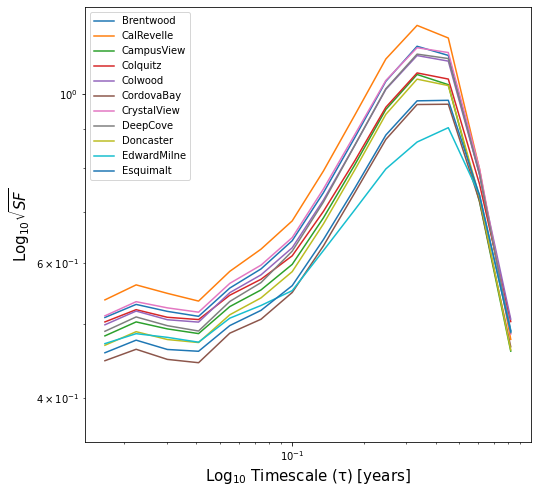

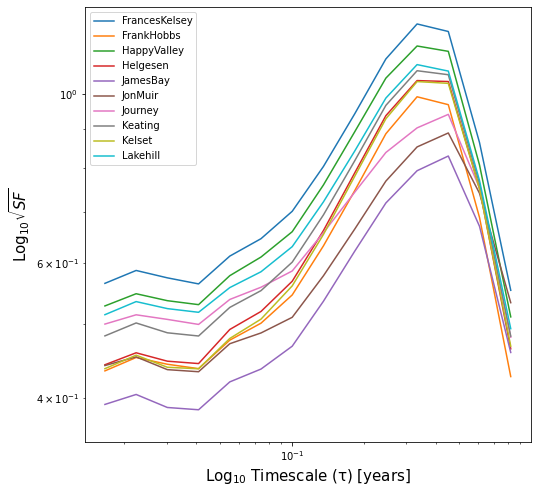

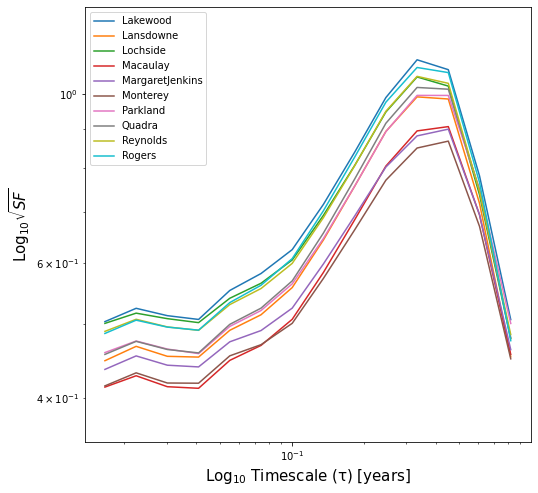

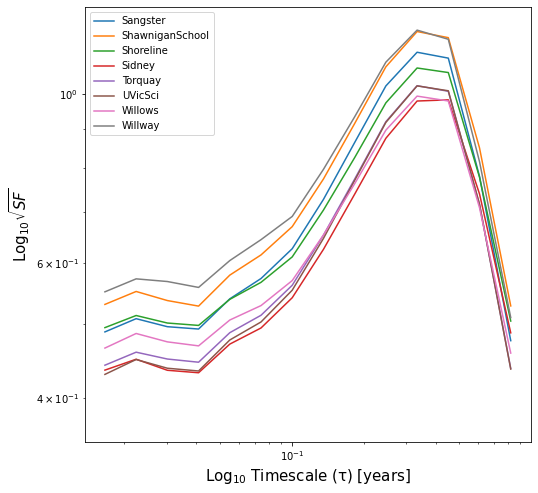

In [210]:
## Plotting the structure functions ##

#Splitting up the SF variable into sections
SF1 = SF[0:11]
label1 = stath[0:11]

SF2 = SF[11:21]
label2 = stath[11:21]

SF3 = SF[21:31]
label3 = stath[21:31]

SF4 = SF[31:40]
label4 = stath[31:40]


plt.figure(figsize=(8,8))
for i in range(len(SF1)):
    plt.plot(bins_years[:-1],SF1[i],label=label1[i])
    plt.xscale('log')
    plt.yscale('log')
    plt.legend()
    plt.ylim(0.35,1.3)
    
    plt.xlabel(r'Log$_{10}$ Timescale (τ) [years]', fontsize = 15)
    plt.ylabel(r'Log$_{10}\sqrt{SF}$', fontsize = 15)
    
#     plt.savefig('SF1.png')
plt.show()

plt.figure(figsize=(8,8))
for i in range(len(SF2)):
    plt.plot(bins_years[:-1],SF2[i],label=label2[i])
    plt.xscale('log')
    plt.yscale('log')
    plt.legend()
    plt.ylim(0.35,1.3)
    
    plt.xlabel(r'Log$_{10}$ Timescale (τ) [years]', fontsize = 15)
    plt.ylabel(r'Log$_{10}\sqrt{SF}$', fontsize = 15)
    
#     plt.savefig('SF2.png')
plt.show()

plt.figure(figsize=(8,8))
for i in range(len(SF3)):
    plt.plot(bins_years[:-1],SF3[i],label=label3[i])
    plt.xscale('log')
    plt.yscale('log')
    plt.legend()
    plt.ylim(0.35,1.3)
    
    plt.xlabel(r'Log$_{10}$ Timescale (τ) [years]', fontsize = 15)
    plt.ylabel(r'Log$_{10}\sqrt{SF}$', fontsize = 15)
    
#     plt.savefig('SF3.png')
plt.show()

plt.figure(figsize=(8,8))
for i in range(len(SF4)):
    plt.plot(bins_years[:-1],SF4[i],label=label4[i])
    plt.xscale('log')
    plt.yscale('log')
    plt.legend()
    plt.ylim(0.35,1.3)
    
    plt.xlabel(r'Log$_{10}$ Timescale (τ) [years]', fontsize = 15)
    plt.ylabel(r'Log$_{10}\sqrt{SF}$', fontsize = 15)
    
#     plt.savefig('SF4.png')
plt.show()